In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_array

In [2]:
class Basis:
    def __init__(self, ops: list[str]):
        self._ops = ops
        self._mapping = {op: i for i, op in enumerate(ops)}
        self._sz = len(ops)
    
    def rank(self, word: str):
        v = self._sz ** (len(word)) - 1
        for i, op in enumerate(reversed(word)):
            v += self._mapping[op] * (self._sz ** i)
        return v

    def unrank(self, pos: int):
        len = 0
        while self._sz ** len - 1 <= pos:
            len += 1
        len -= 1
        pos -= self._sz ** len - 1
        word = [None] * len
        for i in range(len):
            word[i] = self._ops[pos % self._sz]
            pos //= self._sz
        return ''.join(word[::-1])

def commutator(word1: str, word2: str):
    expression = []
    for i in range(len(word1)):
        for j in range(len(word2)):
            # I took the following line from Hartnoll/Xi Yin's code
            word = word1[:i] + word2[j+1:] + word2[:j] + word1[i+1:]
            if word1[i] == 'x' and word2[j] == 'p':
                expression.append('+' + word)
            elif word1[i] == 'p' and word2[j] == 'x':
                expression.append('-' + word)
    return expression

<h2>Semidefinite relaxation of quadratic constraints:</h2>

[Kazakov and Zheng](https://arxiv.org/pdf/2108.04830)

Summary: Relax the quadratic trace cyclicity constraints into a semidefinite representation and solve. Recipe to do this is in Section 4.2, specifically equation (4.21).

In [245]:
# TODO: ground_state_constraints

def schwinger_dyson(hamil: list, word1: str):
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for term in terms:
            if term[0] == '+':
                expression.append((term[1:], coeff))
            else:
                expression.append((term[1:], -coeff))
    return expression

def normalization(B):
    return [B[0] == 1]

def reality(basis: Basis, B, word: str):
    return [B[basis.rank(word[::-1])] == cp.conj(B[basis.rank(word)])]

def symmetry_constraint(G: list, word: str):
    return [(w + word, coeff) for coeff, w in G]

def moment_matrix(basis, B, L):
    n = 2 ** (L//2 + 1) - 1
    M = cp.bmat([[B[basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))] for j in range(n)] for i in range(n)])
    return [M >> 0]

def trace_cyclicity(basis, B, word: str):
    word1 = word
    word2 = word[1:] + word[0]
    row_ind, col_ind, data = [], [], []
    for i in range(1, len(word1)):
        rind = basis.rank(word[1:i])
        cind = basis.rank(word[i+1:])
        if word[0] == 'x' and word[i] == 'p':
            # Required to keep C symmetric
            data.append(0.5j)
            row_ind.append(rind)
            col_ind.append(cind)
            data.append(0.5j)
            row_ind.append(cind)
            col_ind.append(rind)
        elif word[0] == 'p' and word[i] == 'x':
            data.append(-0.5j)
            row_ind.append(rind)
            col_ind.append(cind)
            data.append(-0.5j)
            row_ind.append(cind)
            col_ind.append(rind)
    C = csr_array((data, (row_ind, col_ind)), (B.shape[0], B.shape[0]))
    return C, B[basis.rank(word2)] - B[basis.rank(word1)]

In [246]:
def add_linear_constraints(basis, B, L, constraints, hamil, G):
    constraints.extend(normalization(B))
    constraints.extend(moment_matrix(basis, B, L))
    row_ind, col_ind, data = [], [], []
    numc = 0
    n = B.shape[0]
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for term in terms:
            if basis.rank(term[0]) >= n:
                return
        for term in terms:
            cnt += 1
            new_row = 1
            col_ind.append(basis.rank(term[0]))
            data.append(term[1])
            row_ind.append(numc)
        numc += new_row
    for i in range(n):
        word = basis.unrank(i)
        add_terms(schwinger_dyson(hamil, word))
        add_terms(symmetry_constraint(G, word))
        constraints.extend(reality(basis, B, word))
    if len(col_ind) > 0:
        P = csr_array((data, (row_ind, col_ind)), (numc, n))
        constraints.append(P @ B == 0)
    return constraints

def add_relaxed_quad_constraints(basis, B, constraints):
    n = B.shape[0]
    X = cp.Variable((n, n), 'X')
    for i in range(n):
        word = basis.unrank(i)
        if len(word) < 2:
            continue
        C, D = trace_cyclicity(basis, B, word)
        constraints.append(cp.trace(C @ X) + D == 0)
    constraints.append(cp.bmat([[np.ones((1,1)), B.T], [B, X]]) >> 0)
    return constraints

In [247]:
def create_all_constraints(basis, B, L, hamil, G):
    constraints = []
    add_linear_constraints(basis, B, L, constraints, hamil, G)
    add_relaxed_quad_constraints(basis, B, constraints)
    return constraints

def construct_problem(hamil, L, G):
    basis = Basis(['x','p'])
    B = cp.Variable((2**(L+1) - 1, 1), 'B', complex=True)
    constraints = create_all_constraints(basis, B, L, hamil, G)
    energy = cp.real(sum(coeff * B[basis.rank(word)]  for coeff, word in hamil))
    minprob = cp.Problem(cp.Minimize(energy), constraints)
    return minprob

def solve_energy(L, G, gs, verbose=True):
    mins = np.zeros_like(gs)
    for i, g in enumerate(gs):
        hamil = [(1, 'pp'), (1, 'xx'), (g, 'xxxx')]
        minprob = construct_problem(hamil, L, G)
        if verbose:
            print(f'Solving for T={g}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        if verbose:
            print(f'\tE_min = {E_min}')
        mins[i] = E_min
    return mins

In [248]:
L = 4
G = [(1j, 'xp'), (-1j, 'px'), (1, '')]
gs = np.linspace(0, 4, num = 20)

In [249]:
mins4, xxs4 = solve_energy(L, G, gs, verbose=False)

KeyboardInterrupt: 

In [26]:
def analytical_energy(g):
    a2 = (1/(24 * g)) * (np.sqrt(1 + 48 * g) - 1)
    return 1 + (1 / 24) * (a2 - 1) * (9 - a2) - 0.5 * np.log(a2)

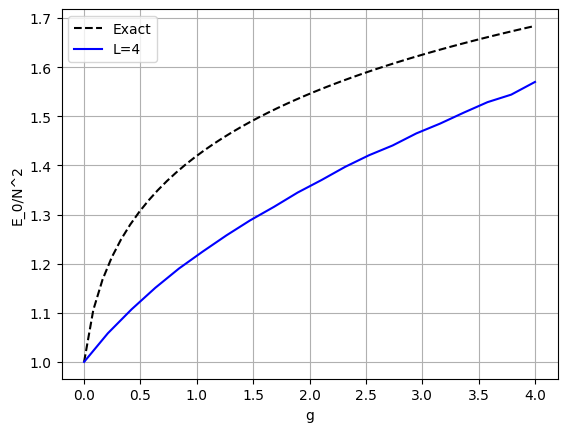

In [27]:
plt.plot(np.linspace(1e-6,4), analytical_energy(np.linspace(1e-6,4)), c='black', linestyle='--', label='Exact')
plt.plot(gs, mins4, c='blue', label='L=4')
# plt.scatter(gs, mins4, c='red', s=10)
plt.xlabel('g')
plt.ylabel('E_0/N^2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.plot(np.linspace(1e-6,4), analytical_energy(np.linspace(1e-6,4)), c='black', linestyle='--', label='Exact')
plt.plot(gs, mins4, c='blue', label='L=4')
# plt.scatter(gs, mins4, c='red', s=10)
plt.xlabel('g')
plt.ylabel('tr<XX>/N^2')
plt.legend()
plt.grid()
plt.show()

<h2>Sequential trust-region search:</h2>

[Han and Hartnoll](https://arxiv.org/pdf/2004.10212)

Summary: We use trust-region search to slowly converge to a solution. We linearize our quadratic constraints around the current point, and try to extremize our objective within a connected region of parameter space where we trust our linearized constraints to be a good approximation of the problem. The exact shape of the trust region depends on the norm used. We use the 2-norm, which results in a ball of some radius $\rho$.

- Phase 1: Minimise violation of linear constraints as the objective. Stop targets: violation/residual (2-norm of linear constraints) and convergence (2-norm of update step). Linearized quadratic constraints and moment matrix are the constraints.
- Phase 2:

I have a set of linear constraints. I can explicitly set $\langle trI \rangle$ = 1 in my functions. There are also some linear constraints from trace cyclicity of 2 operator strings. Just $\langle tr XP \rangle - \langle tr PX \rangle$ though.

- $\langle tr XP \rangle - \langle tr PX \rangle$ constraint currently not included.

Stuff is complex. I will use a vector $x$ of length $2n$. The mapping for the $i$-th variable is $x_{2i}$ = real part, $x_{2i+1}$ = complex part.

In [3]:
class LinConstraints:
    # Px = b
    def __init__(self, M, b):
        self._M = M
        self._b = b
    def __call__(self, a):
        return self._M @ a
    def grad(self, a):
        return self._M
    def rhs(self):
        return self._b

class QuadConstraint:
    def __init__(self, M, N):
        self._M = M
        self._N = N
    def __call__(self, a):
        return self._N.T @ a + a.T @ self._M @ a
    def grad(self, a):
        return self._N + 2 * self._M @ a
    def hess(self):
        return self._M
    def rhs(self):
        return 0

In [4]:
# TODO: ground_state_constraints
# Normalization is accounted for in add_linear_constraints

def schwinger_dyson(hamil: list, word1: str):
    # Calculate <[H,O]>. Returns a list of (word, coeff).
    expression = []
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for term in terms:
            if term[0] == '+':
                expression.append((term[1:], coeff))
            else:
                expression.append((term[1:], -coeff))
    return expression

def reality(basis, word: str):
    # Return <trO> = <trO+>* (+ is dagger).
    i = basis.rank(word[::-1])
    j = basis.rank(word)
    return [[(2 * i, 1), (2 * j, -1)], [(2 * i + 1, 1), (2 * j + 1, 1)]]

def symmetry_constraint(G: list, word: str):
    # Calculate <trGO> = 0. Returns a list of (word, coeff).
    return [(w + word, coeff) for coeff, w in G]

def moment_matrix(basis, B, L):
    # Return moment matrix of operators.
    # https://physics.stackexchange.com/questions/130614/complex-semi-definite-programming
    # https://dl.acm.org/doi/10.1145/380752.380838
    n = 2 ** (L//2 + 1) - 1
    Mr = cp.bmat([[B[2 * basis.rank(basis.unrank(i)[::-1] + basis.unrank(j))] for j in range(n)] for i in range(n)])
    Mc = cp.bmat([[B[2 * basis.rank(basis.unrank(i)[::-1] + basis.unrank(j)) + 1] for j in range(n)] for i in range(n)])
    return cp.bmat([[Mr, -Mc], [Mc, Mr]])

def trace_cyclicity(basis, L, word: str):
    # Calculate <trAB> - <trBA>. Returns C in xT@C@x + (this too) <trBA> - <trAB> = 0.
    n = 2 ** (L + 1) - 1
    word1 = word
    word2 = word[1:] + word[0]
    row_indr, col_indr, datar = [], [], []
    row_indc, col_indc, datac = [], [], []
    for i in range(1, len(word)):
        w1ind = basis.rank(word[1:i])
        w2ind = basis.rank(word[i+1:])
        k = 0
        if word[0] == 'x' and word[i] == 'p':
            k = 0.5
        elif word[0] == 'p' and word[i] == 'x':
            k = -0.5
        row_indr.extend([2 * w1ind, 2 * w2ind + 1, 2 * w1ind + 1, 2 * w2ind])
        col_indr.extend([2 * w2ind + 1, 2 * w1ind, 2 * w2ind, 2 * w1ind + 1])
        datar.extend([-k, -k, -k, -k])
        row_indc.extend([2 * w1ind, 2 * w2ind, 2 * w1ind + 1, 2 * w2ind + 1])
        col_indc.extend([2 * w2ind, 2 * w1ind, 2 * w2ind + 1, 2 * w1ind + 1])
        datac.extend([k, k, -k, -k])
    Cr = csr_array((datar, (row_indr, col_indr)), (2 * n, 2 * n))
    Dr = np.zeros((2 * n, 1))
    Dr[2 * basis.rank(word2), 0] = 1
    Dr[2 * basis.rank(word1), 0] = -1
    Cc = csr_array((datac, (row_indc, col_indc)), (2 * n, 2 * n))
    Dc = np.zeros((2 * n, 1))
    Dc[2 * basis.rank(word2) + 1, 0] = 1
    Dc[2 * basis.rank(word1) + 1, 0] = -1
    return [QuadConstraint(Cr, Dr), QuadConstraint(Cc, Dc)]

In [5]:
def add_linear_constraints(basis, L, hamil, G):
    row_ind, col_ind, data = [0], [0], [1] # This handles the normalization
    numc = 1
    n = 2 ** (L + 1) - 1
    def add_terms(terms):
        nonlocal numc
        new_row = 0
        cnt = 0
        for pos, coeff in terms:
            if pos >= 2 * n:
                return
        for pos, coeff in terms:
            cnt += 1
            new_row = 1
            col_ind.append(pos)
            data.append(coeff)
            row_ind.append(numc)
        numc += new_row
    def preprocess(terms):
        # we have a list terms of form (term, coeff) where term is a string
        # what we have to do separate out the real and complex parts
        # and return a list (i, coeff) where i is the position in the vector B
        realterm = []
        complexterm = []
        for term, coeff in terms:
            i = basis.rank(term)
            cr = np.real(coeff)
            cc = np.imag(coeff)
            realterm.extend([(2 * i, cr), (2 * i + 1, -cc)])
            complexterm.extend([(2 * i, cc), (2 * i + 1, cr)])
        return realterm, complexterm
    # for i in range(n):
    #     word = basis.unrank(i)
    #     realterm, complexterm = preprocess(schwinger_dyson(hamil, word))
    #     add_terms(realterm)
    #     add_terms(complexterm)
    #     realterm, complexterm = preprocess(symmetry_constraint(G, word))
    #     add_terms(realterm)
    #     add_terms(complexterm)
    #     realterm, complexterm = reality(basis, word)
    #     add_terms(realterm)
    #     add_terms(complexterm)
    # Px = b
    P = csr_array((data, (row_ind, col_ind)), (numc, 2 * n))
    b = np.zeros((numc, 1))
    b[0, 0] = 1
    return LinConstraints(P, b)

def add_quad_constraints(basis, L):
    quad_constraints = []
    n = 2 ** (L + 1) - 1
    for i in range(n):
        word = basis.unrank(i)
        if len(word) < 2:
            continue
        quad_constraints.extend(trace_cyclicity(basis, L, word))
    return quad_constraints

In [17]:
L = 4
G = [(1j, 'xp'), (-1j, 'px'), (1, '')]
# hamil = [(1, 'pp'), (1, 'xx'), (1, 'xxxx')]
hamil = [(1, 'pp'), (1, 'xx')]

In [18]:
# This creates the vector
basis = Basis(['x','p'])
n = 2 ** (L + 1) - 1
B = cp.Variable((2 * n, 1), 'B')
# This creates the constraints
linear_constraints = add_linear_constraints(basis, L, hamil, G)
quadratic_constraints = add_quad_constraints(basis, L)
M = moment_matrix(basis, B, L)

In [20]:
A = np.zeros((2 * n, 1))
Mcur = np.zeros(M.shape)

def step(lincons, A, B, Mcur, M, quadcons):
    objective = cp.Minimize(cp.norm2(lincons(A) + lincons(B) - lincons.rhs()))
                            # + cp.sum([cp.norm2(q(A) + q.grad(A).T @ B) for q in quadcons]))
    constraints = []
    constraints.append(Mcur + M >> 0)
    constraints.append(cp.norm2(B) <= 1e-2)
    constraints.extend([q(A) + q.grad(A).T @ B == q.rhs() for q in quadcons])
    minprob = cp.Problem(objective, constraints)
    minprob.solve()
    print(objective.value)
    print(max(B.value.T @ q.hess() @ B.value for q in quadcons))
    return B.value, M.value

for _ in range(40):
    V, W = step(linear_constraints, A, B, Mcur, M, quadratic_constraints)
    A += V
    Mcur += W
    # print(max([abs(q(A) - q.rhs()) for q in quadratic_constraints]))
    # print(max(abs(linear_constraints(A) - linear_constraints.rhs())))

0.9899999993839429
[[0.0001]]
0.9949995699812072
[[2.49957062e-05]]
0.9974996671062816
[[6.25048563e-06]]
0.9987497640022935
[[1.56274225e-06]]
0.9993747929379707
[[3.9066117e-07]]
0.9996873887898524
[[9.77161666e-08]]
0.9998436639139114
[[2.44219144e-08]]
0.9999218279417869
[[6.10961525e-09]]
0.9999609051832945
[[1.5270308e-09]]
0.9999802358121921
[[3.73673214e-10]]
0.9999901168875848
[[9.76356509e-11]]
0.9999896632770533
[[2.05762514e-13]]
0.9999947193562613
[[2.5563937e-11]]
0.9999940391616806
[[4.62664667e-13]]
0.9999967793490029
[[7.50862656e-12]]
0.999997214751331
[[1.89575187e-13]]
0.9999957424931832
[[2.16754405e-12]]
0.9999950311327481
[[5.06033669e-13]]
0.9999942357224681
[[6.32677514e-13]]
0.9999936462601708
[[3.474658e-13]]
0.9999966500513956
[[9.02276172e-12]]
0.999998003224381
[[1.83107713e-12]]
0.9899979935292262
[[0.0001]]
0.9949985750517489
[[2.50058156e-05]]
0.9974991695990907
[[6.25297309e-06]]
0.9987495153245988
[[1.56336443e-06]]
0.9993746688533159
[[3.90816934e-07

In [ ]:
def solve_energy(L, G, gs, verbose=True):
    mins = np.zeros_like(gs)
    for i, g in enumerate(gs):
        hamil = [(1, 'pp'), (1, 'xx'), (g, 'xxxx')]
        minprob = construct_problem(hamil, L, G)
        if verbose:
            print(f'Solving for T={g}, i={i}:')
        E_min = minprob.solve(accept_unknown=True)
        if verbose:
            print(f'\tE_min = {E_min}')
        mins[i] = E_min
    return mins

In [ ]:
class Solver:
    def __init__(self, constraints: list[LinConstraints|QuadConstraint], objective,
                 v, B, initial_point, max_quad_tol, max_trust_radius):
        self._C = constraints
        self._v = v # This is the array of variables
        self._B = B # This is the moment matrix
        self._obj = objective # This is the objective to minimise
        self._a = initial_point # This is the initial point
        self._res = 0 # TODO: This must be a function of the initial point! This is the final answer.
        self._max_quad_tol = max_quad_tol # Maximum violation of quadratic constraints
        self._max_trust_radius = max_trust_radius # Maximum value of trust region radius

    def step(self):
        """
        Take in a, and return a new point a_new.
        The objective is linear, so no problems in minimizing it directly.
        """
        # Linear and quadratic constraints
        constraints = [c(self._a) + c.grad(self._a).T @ self._v == c.rhs() for c in constraints]
        # Positive semidefinite constraint
        constraints.append(self._B + self._B.value >> 0)
        # Trust region radius
        constraints.append(cp.norm2(self._v) <= self._max_trust_radius)
        # Now solve
        prob = cp.Problem(cp.Minimize(self._obj), constraints)
        prob.solve()
        return self._a + self._v.value
    
    def accept_step(self):
        """
        This is always called just after step(), so the value of v is preserved.
        The strategy is:
        1.  Reject the step if the 2-norm of the deviation from the quadratic constraints
            exceeds maximum tolerance and decrease trust region radius.
        2.  Reject the step if the value of self._obj
        """

    def solve(self):
        """
        Solve the problem by taking steps.
        """